# Binary Classification of Brain Tumours using a Support Vector Machine (SVM) with SIFT feature extraction and k-Means clustering.

For more information on the background of this notebook, please see README.md and the supplementary report. A summary of the entire workflow of this notebook and the motivation behind it is given there.

In [1]:
# Utility libraries
%matplotlib inline
from IPython.display import clear_output
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Machine learning and image management libraries
import cv2
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

The cell below defines key constants of the notebook below. These are free to be changed

The data is loaded from locations relative this directory. Change the dataset location as necessary below.
The below two cells work under the assumption that the filenames and labels located in 'label.csv' exactly match the images found in the 'images' directory, for both the dataset and the external test set.

In [2]:

# First is a directory containing the images themselves.
# Second is a csv file containing filenames and labels.
DATASET_LOCATION = "..\\..\\Assignment Kit\\dataset\\images\\"
DATASET_LABEL_LOCATION = "..\\..\\Assignment Kit\\dataset\\label.csv"

# First is a directory containing the images themselves.
# Second is a csv file containing filenames and labels.
TEST_SET_LOCATION = "..\\..\\Assignment Kit\\test_set\\images\\"
TEST_SET_LABEL_LOCATION = "..\\..\\Assignment Kit\\test_set\\label.csv"

# The directory in which to store pre-processed images, or the directoy in which
# pre-processed images will be found if they have already been pre-processed.
PROCESSED_DATASET_LOCATION = "..\\..\\Assignment Kit\\dataset\\processed_images\\"

# Directory to (optionally) save data produced throughout notebook.
# The current value agrees with .gitignore.
DATA_SAVE_LOCATION = "SVM_SFT_saved_data\\"
DESCRIPTOR_TRAINING_SET_FILENAME = "descriptor_training_set.npy"

# Defines range of K values (hyperparameter) to try. Note: Most be postive integers.
# Number of K values tried is (STOP - START) / STEP.
# Syntax is np.arange(START, STOP, STEP)
# STOP is not inclusive hence increment it by STEP to ensure it is in included.
K_VALS = np.arange(20, 60 + 10, 10).tolist()

# Defines range of hyperparameter for regularisation C = 1 / \lambda used when cross validating SVMs.
C_VALS = np.arange(0.001, 0.08 + 0.001, 0.001).tolist()

# Flags to change operation of notebook. Flag names are informative.
EXTRACT_FEATURES_EVEN_IF_EXTRACTED_BEFORE = False
SAVE_TRAIN_SET_OF_ALL_DESCRIPTORS = True
SAVE_TEST_SET_OF_ALL_DESCRIPTORS = False
FIND_K_MEANS_CLUSTERS_EVEN_IF_FOUND_BEFORE = False
SAVE_K_MEANS_INSTANCES = True
K_MEANS_FILENAME_POSTAMBLE = "_kmeans_object.pkl"   # For k = 50, sklearn.cluster.KMeans instance will be saved as "50_kmeans_object.pkl".
K_MEANS_NUMBER_OF_RUNS = 2                          # Per K value
K_MEANS_MAX_ITERATIONS = 200                        # Per run per K value. Algorithm will return anyway if it converges within the default tolerance.
K_MEANS_VERBOSE_LEVEL = 6                           # Set this is 0 for no output, 6 for max output.

if (SAVE_TRAIN_SET_OF_ALL_DESCRIPTORS
    or SAVE_TEST_SET_OF_ALL_DESCRIPTORS):
    if not os.path.isdir(DATA_SAVE_LOCATION):
        os.mkdir(DATA_SAVE_LOCATION)

print("#K_VALS = {}. K_VALS = {}.".format(len(K_VALS), K_VALS))
print("#C_VALS = {}. C_VALS = {}.".format(len(C_VALS), [float("%.4f" % C) for C in C_VALS]))

#K_VALS = 5. K_VALS = [20, 30, 40, 50, 60].
#C_VALS = 80. C_VALS = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05, 0.051, 0.052, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08].


In [27]:
# Loads data into numpy array of strings.
# Header is skipped as given by skip_header = 1.
# The header in the expected file is "file_name" and "label".
# Therefore, indexing the 0'th element in a row references the filenames and indexing the 1'th element in a row references the label

data = np.genfromtxt(DATASET_LABEL_LOCATION, delimiter = ',', dtype = str, skip_header = 1)

num_images = data.shape[0]

# As this a binary classification task, we can rename all labels which are not 'no_tumor' to 'tumor'.
# This will prevent many further comparisons in future.
for i in range(num_images):
    if (data[i][1] != "no_tumor"):
        data[i][1] = "tumor"

print("There are {} images in the dataset.".format(num_images))

There are 3000 images in the dataset.


## Data Pre-Processing

The images in the dataset are given as RGB images. This means that each pixel has three corresponding values due to the three colour channels. In the analysis given here, only the greyscale images are needed. That is, each pixel only has one corresponding due to the single colour channel. To enforce this, we pre-process the images to save them in greyscale format. These are then saved in an alternate directory as given by `PROCESSED_DATASET_LOCATION`.

Additionally, the SIFT functionality as implemented by `sklearn` only accepts single colour channel images of unsigned 8 bit datatype. Therefore, the images formed below are normalised as such. Min-Max normalisation here is used with relative safety as much of the dataset does not include spikes in intensity that would force the normaliser to fully normalise any details away. However, this method can lead to some images in the dataset being more 'illuminated' than others. Even though this is the nature of the un-pre-processed dataset anyways, fortunately the SIFT feature detection method is robust to illumination variation.

To ensure that the images are read correctly after they have been processed, the flag `cv2.IMREAD_GRAYSCALE` must be passed when calling `cv2.imread( ... )`.

In [4]:
if not (os.path.isdir(PROCESSED_DATASET_LOCATION)):
    os.mkdir(PROCESSED_DATASET_LOCATION)

    for i in range(num_images):
        image_string = "IMAGE_" + str(i).zfill(4)
        
        image = cv2.imread(DATASET_LOCATION + image_string + ".jpg")
        
        # Convert colour image to greyscale
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Normalise image such that pixel values are unsigned 8 bit
        processed_image = cv2.normalize(grey_image, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
        
        cv2.imwrite(PROCESSED_DATASET_LOCATION + image_string + ".jpg", processed_image)
        
        if (i % 100 == 0):
            clear_output(wait = True)
            print("{} / {} images processed.".format(i, num_images))
    
    clear_output(wait = True)
    print("Image processing done! {} images were processed!".format(num_images))
    
else:
    print("Data has already been pre-processed!")

Data has already been pre-processed!


Now, we output some random examples from the dataset just to visualise what we are working with. Feel free to run the cell multiple times to see more images in the dataset.

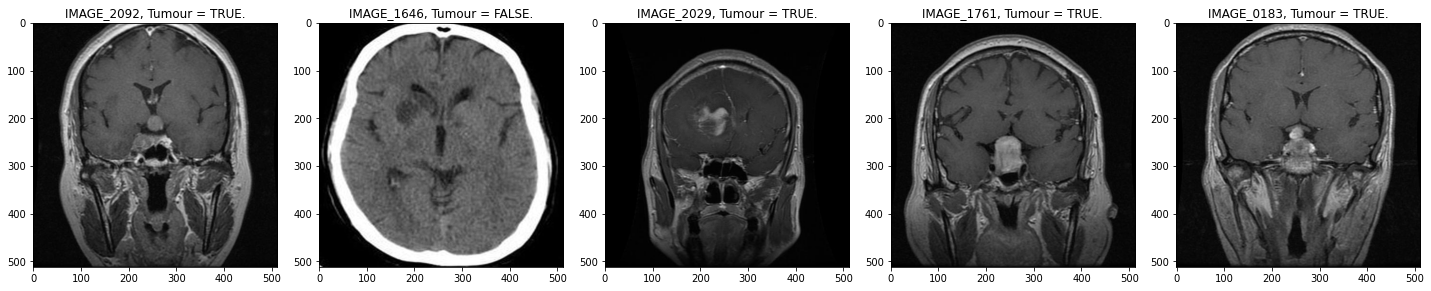

In [5]:
fig, ax = plt.subplots(1, 5, figsize = (20, 4))

for i in range(5):
    image_num = np.random.randint(0, num_images - 1)
    image_string = "IMAGE_" + str(image_num).zfill(4)
    
    ax[i].imshow(cv2.imread(PROCESSED_DATASET_LOCATION + image_string + ".jpg", cv2.IMREAD_GRAYSCALE), cmap = "gray")
    ax[i].set_title("{}, Tumour = {}.".format(image_string, "TRUE" if (data[i][1] != "no_tumor") else "FALSE"))
    
plt.tight_layout()

## SIFT Feature Extraction and Compilation

Here, the SIFT framework is used to extract SIFT keypoints and their corresponding descriptors from the images in the dataset.

There are a few free/hyper parameters that are available for exploration. These parameters include the SIFT parameters: the number of octaves, the number of scale levels, the standard deviation used in the Laplacian of Gaussian (LoG) operation $\sigma$, and others. Another hyperparameter is the number of centroids/cluster's provided to the k-Means clustering algorithm $K$. This hyperparameter $K$ is the only hyperparameter explored here due to the SIFT parameters exerting significantly less influence on the final accuracy when compared to $K$.

ALL SIFT features extracted from the training set images are used. This may seem excessive however this is deemed possible with the help of a brief calculation, as follows. The 3000 images in the dataset appear to have an average of 1000 features (empircally found). The descriptor for each feature is 128 dimensional vector with each entry being an unsigned integer small enough to fit inside an unsigned byte representation - 8 bits. Therefore, the minimum memory requirement for storing the feature descriptors for future k-means clustering can be justified to be $3000 \times 1000 \times 128 \times 8 \approx 3 \times 10^{9}$ bits. This is approximately 300 megabytes. This is well within the memory capabilities of most modern machines even if the language used is Python which of course it is here.

As will be seen later on, we need to keep track of how many features are found in each image. To do this, we intialise the list below and append to it in `build_set` which is defined further below. This is done such that the number of features found in image $n$ is `num_key_points_list[n]`.

In [6]:
# See markdown cell above for documentation.
num_key_points_list = np.zeros(num_images, dtype = np.uint)

622 key points found in example image "IMAGE_0820".
For example, key point 409 of the image is represented by the following descriptor vector:
[ 14  10   6   8  10   3   7  14   5  10   6   8   8  11  91  46  29  37
   1   0   0  23  59  30  29  18   2   0   0   4  15  52  60   9   2   0
   1   6   8  77 131  12   0   0   7  47 109 131  25   1   0   0  51 131
  97  50  85   1   0   0   2  13  21  86  61   4   0   1   2   3   9  85
 131  27   0   0  14  14  11 106  52   6   0   0 118 131  19  15  44  10
   1   0   7  40  27  30  16   4   1   0   0   0  35 131  37   5  10   4
   3   4  48 131   9   1  10   7  30  80  14  10   1   3   4  14  47  59
   4   0]


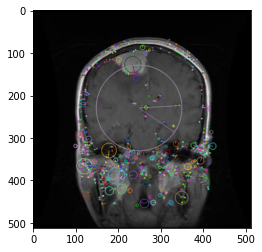

In [7]:
sift = cv2.SIFT_create()

image_string = "IMAGE_" + str(np.random.randint(0, num_images - 1)).zfill(4)
image = cv2.imread(PROCESSED_DATASET_LOCATION + image_string + ".jpg", cv2.IMREAD_GRAYSCALE)

key_points, descriptors = sift.detectAndCompute(image, None)
descriptors = descriptors.astype(np.ubyte)

image = cv2.drawKeypoints(image, key_points, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print("{} key points found in example image \"{}\".".format(len(key_points), image_string))

example_desc_num = np.random.randint(0, len(key_points))
print("For example, key point {} of the image is represented by the following descriptor vector:".format(example_desc_num))
print(descriptors[example_desc_num])

plt.imshow(image)

In [8]:
def build_set(data_, filename):
    # Given a (N \times 2) numpy array with the first column containing the filenames of the images
    # and the second row containing the images labels (as given with the data for this task),
    # this function returns a list of the descriptors of the features found from images in the dataset.
    # The array desc_set is re-sized for every image which makes this function fairly clunky. However, this is
    # by far the simplest method to implement it. An attempt was made to implement it by estimating the total number
    # of descriptors to prevent frequent re-allocation but in the end Occam's razor prevails.
    
    # Parameter data_ is named as such to prevent confusion with the global 'data' used elsewhere in this notebook.
    # The filename parameter is the filename to save the found dataset as. It should end with the extension .npy.
    
    print("Beginning feature extraction and computation...")
    
    sift = cv2.SIFT_create()
    
    desc_set = np.empty((0, 128), dtype = np.ubyte)
    
    for i in range(data_.shape[0]):
        
        if ((i % 100 == 0) and (i != 0)):
            clear_output(wait = True)
            print("Features extracted and processed from {} images (there are {} total).".format(i, data_.shape[0]))
        
        image = cv2.imread(PROCESSED_DATASET_LOCATION + "IMAGE_" + str(i).zfill(4) + ".jpg", cv2.IMREAD_GRAYSCALE)
        
        _, descriptors = sift.detectAndCompute(image, mask = None)
        
        descriptors = descriptors.astype(np.ubyte)
        
        # Take note of how many key points were found
        num_key_points_list[i] = len(descriptors)
        
        desc_set = np.append(desc_set, descriptors, axis = 0)
    
    clear_output(wait = True)
    print("Finished building {}!".format(filename))
    
    # Save generated description set if told to
    if (SAVE_TRAIN_SET_OF_ALL_DESCRIPTORS):
        np.save(DATA_SAVE_LOCATION + filename, desc_set)
        print("{} successfully saved.".format(DATA_SAVE_LOCATION + filename))
    
    return desc_set

In [9]:
if (EXTRACT_FEATURES_EVEN_IF_EXTRACTED_BEFORE):
    descriptor_training_set = build_set(data, DESCRIPTOR_TRAINING_SET_FILENAME)
    
else:
    # Attempt to load previous pre-processed training set
    try:
        descriptor_training_set = np.load(DATA_SAVE_LOCATION + DESCRIPTOR_TRAINING_SET_FILENAME)
        print("Descriptor training set successfully loaded from {}.".format(DATA_SAVE_LOCATION + DESCRIPTOR_TRAINING_SET_FILENAME))
        
    except FileNotFoundError:
        print("Descriptor training set could not be loaded from {}.".format(DATA_SAVE_LOCATION + DESCRIPTOR_TRAINING_SET_FILENAME))
        
        descriptor_training_set = build_set(data, DESCRIPTOR_TRAINING_SET_FILENAME)

print("For sanity checking, the shape of the descriptor training set numpy array is ({}, {}).".format(descriptor_training_set.shape[0], descriptor_training_set.shape[1]))

Finished building descriptor_training_set.npy!
SVM_SFT_saved_data\descriptor_training_set.npy successfully saved.
For sanity checking, the shape of the descriptor training set numpy array is (2717148, 128).


# Using k-Means Clustering to Produce a "Visual Vocabulary"

The 'inertia' displayed below is a measure of the sum of the squared distances of the samples to their closest cluster centroid.

In [10]:
def find_k_means_clusters(k, desc_set):
    # Parameter desc_set is the training/test set being a numpy array containing all the
    # SIFT descriptors for the SIFT features found in ALL of the dataset, be it training or test.

    print("Beginning k-Means clustering for k = {}. There will be {} runs.".format(k, K_MEANS_NUMBER_OF_RUNS))
    print("(Initialisation can take up to two minutes for each run).")

    # Initialise kMeans class instance
    kmeans = KMeans(
        n_clusters = k,
        init = "k-means++",
        n_init = K_MEANS_NUMBER_OF_RUNS,
        max_iter = K_MEANS_MAX_ITERATIONS,
        verbose = K_MEANS_VERBOSE_LEVEL
    )
    
    # Run the k-means clustering algorithm
    kmeans.fit(desc_set)
    
    clear_output(wait = True)
    print("Finished building and fitting kmeans instance for k = {}.".format(k))
    
    # Save the kmeans object using the pickle library
    if (SAVE_K_MEANS_INSTANCES):
        pickle.dump(kmeans, open(DATA_SAVE_LOCATION + str(k) + K_MEANS_FILENAME_POSTAMBLE, "wb"))
        print("{} successfully saved.".format(DATA_SAVE_LOCATION + str(k) + K_MEANS_FILENAME_POSTAMBLE))
    
    return kmeans

In [11]:
k_means_instances = {}

for k in K_VALS:
    
    # If k_means_instances dictionary is already partially populated, display what has already been found.
    if (k != K_VALS[0]):
        clear_output(wait = True)
        print("Have already fitted/loaded kmeans instances for k = {}.\n".format(str(list(k_means_instances))))
    
    if (FIND_K_MEANS_CLUSTERS_EVEN_IF_FOUND_BEFORE):
        kmeans = find_k_means_clusters(k, descriptor_training_set)
    else:
        # Attempt to load previously found kmeans centres
        try:
            kmeans = pickle.load(open(DATA_SAVE_LOCATION + str(k) + K_MEANS_FILENAME_POSTAMBLE, "rb"))
            print("KMeans instance SUCCESSFULLY loaded from {}.".format(DATA_SAVE_LOCATION + str(k) + K_MEANS_FILENAME_POSTAMBLE))
            
        except FileNotFoundError:
            print("KMeans instance COULD NOT be loaded from {}.".format(DATA_SAVE_LOCATION + str(k) + K_MEANS_FILENAME_POSTAMBLE))
            
            kmeans = find_k_means_clusters(k, descriptor_training_set)
    
    # With kmeans instance either loaded or fitted, store the instance in the k_means_instances dictionary.
    # Remember, a fitted kmeans instance contains the cluster centres amongst other important attributes.
    k_means_instances[k] = kmeans

clear_output(wait = True)
print("Finished! Instances of kmeans have been fitted/loaded for k = {}.".format(str(list(k_means_instances))))

Finished! Instances of kmeans have been fitted/loaded for k = [20, 30, 40, 50, 60].


## Building Feature Vector Dataset

With our "visual vocabularies" for various $k$ produced, we next need to translate our image dataset into frequency histograms with bases defined by the k-Means clustering as above.

In [28]:
if (True):
    k = 20
    
    print("Begginning process of translating clustered descriptor sets into feature vectors for every image with k = {}.".format(k))
    
    # Initialise empty array in which to store the found histograms for each image
    training_hists = np.zeros((num_images, k), dtype = np.uint)
    
    # Helps in slicing descriptor_training_set
    slice_start = 0
    slice_stop = num_key_points_list[0]

    for i in range(num_images - 1):
        # Slice descriptor slicing set correctly and put cluster count in hist which is of length k.
        hist = np.bincount(k_means_instances[k].predict(descriptor_training_set[slice_start:slice_stop]), minlength = k)
        
        training_hists[i] = hist
        
        slice_start = slice_stop
        slice_stop += num_key_points_list[i + 1]
        
        if (i % 100 == 0):
            clear_output(wait = True)
            print("Descriptor collections corresponding to {} images processed.".format(i))

    # Do last element separately to ensure an array addressing error is avoided
    hist  = np.bincount(k_means_instances[k].predict(descriptor_training_set[slice_start:]), minlength = k)
    training_hists[-1] = hist

clear_output(wait = True)
print("Finished! {} descriptor collections processed and stored in training_hists.".format(num_images))


Finished! 3000 descriptor collections processed and stored in training_hists.


In [29]:
print(training_hists.shape)

(3000, 20)


In [15]:
help(k_means_instances[20])

Help on KMeans in module sklearn.cluster._kmeans object:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` observations (rows) at random from data
 |      for the 